In [5]:
# install requirements
!pip install matplotlib
!pip install pandas

In [6]:
ONLY_MIXTRAL = False
ADD_TUNED_MODEL = True

In [7]:
import json
import matplotlib.pyplot as plt
import os

print(os.getcwd())
os.chdir("/home/ubuntu/synthetic-data-blog")

# Replace 'file1.json' and 'file2.json' with your actual file paths
file_paths = [
    "./data/metrics_HF_2024-02-06-21-57_mixtral.json",
    "./data/metrics_OAI_2024-02-06-21-38_gpt-35-turbo-0613.json",
    "./data/metrics_OAI_2024-02-07-08-47_gpt-4-0125-preview.json"
]
#data_names = ["66agree", "66agree_3iter", "75agree", "75agree_3iter", "allagree", "allagree_3iter", "allagree_2", "allagree_5iter"]
data_names = [
    "mixtral-8x7B-Instruct-v0.1 (simple prompt)", "mixtral-8x7B-Instruct-v0.1 (CoT-only)", "mixtral-8x7B-Instruct-v0.1 (CoT + SC)",
    "gpt-3.5-turbo-0613 (simple prompt)", "gpt-3.5-turbo-0613 (CoT-only)", "gpt-3.5-turbo-0613 (CoT + SC)",
    "gpt-4-0125-preview	(simple prompt)", "gpt-4-0125-preview (CoT-only)", "gpt-4-0125-preview (CoT + SC)"
]

# Load the data from JSON files
data = []
for file_path in file_paths:
    with open(file_path, 'r') as file:
        data.append(json.load(file))

# Extract accuracy scores
metric = "accuracy"
metrics_lst = [[d["metrics_single"][metric], d["metrics_single_cot"][metric], d["metrics_multiple_cot"][metric]] for d in data]
# unnest list
metrics_lst = [item for sublist in metrics_lst for item in sublist]

# adding autotrain info
data_names += ["RoBERTa-base (Mixtral CoT+SC data)"]
metrics_lst += [0.9403973509933775]  # accuracy: 0.9403973509933775, f1_macro: 0.9419047545594874. See autotrain log file: logs_autotrain-roberta.rtf

print(metrics_lst)


/home/ubuntu/synthetic-data-blog
[0.9161147902869757, 0.9315673289183223, 0.9403973509933775, 0.847682119205298, 0.869757174392936, 0.8830022075055187, 0.9403973509933775, 0.8896247240618101, 0.8962472406181016, 0.9403973509933775]


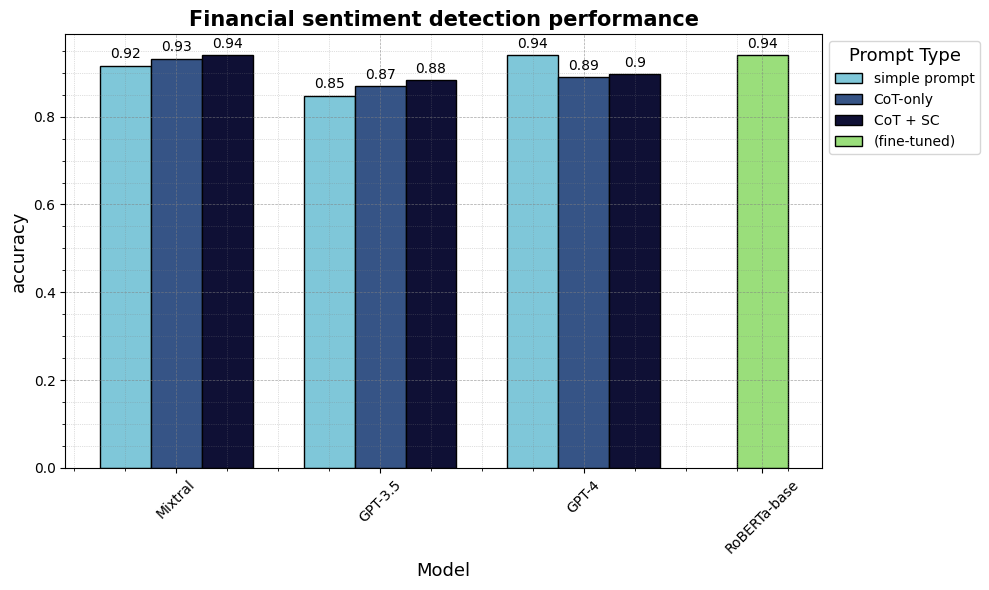

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming data_names and metrics_lst are already defined and loaded as per your initial setup

# Setup for the new grouped bar chart
categories = ['simple prompt', 'CoT-only', 'CoT + SC']
color_palette = ["#7FC7D9", "#365486", "#0F1035"]
n_categories = len(categories)  # Number of metric types

# Extract the unique model types from data_names for labels (assuming they are in order)
if ONLY_MIXTRAL:
    model_labels = ["Mixtral"] #["Mixtral", "GPT-3.5", "GPT-4"]
    metrics_lst_cl = metrics_lst[0:3]
else:
    model_labels = ["Mixtral", "GPT-3.5", "GPT-4"]
    metrics_lst_cl = metrics_lst

# Calculate the number of models
n_models = len(model_labels)

# Setting up the positions for the groups
index = np.arange(n_models) * n_categories * 0.2  # Spacing between groups of bars

# Bar width
bar_width = 0.15

# Creating the plot
fig, ax = plt.subplots(figsize=(10, 6))

for i, category in enumerate(categories):
    # Extracting metrics for each category
    metrics_for_category = [metrics_lst_cl[j] for j in range(len(metrics_lst_cl)) if categories[i] in data_names[j]] + [None] * (n_models - len([metrics_lst_cl[j] for j in range(len(metrics_lst_cl)) if categories[i] in data_names[j]]))  # Adjust for any missing categories
    # Adding bars for this category
    bars = ax.bar(index + i * bar_width, metrics_for_category, bar_width, label=category, color=color_palette[i], edgecolor='black')

    # Adding values on top of bars
    for bar in bars:
        yval = bar.get_height()
        if yval:  # Check if yval is not None
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

    
if ADD_TUNED_MODEL:
    # Calculate the position for the additional "RoBERTa-base" metric column
    # It will be positioned to the right of the last category of the existing groups
    additional_column_position = index[-1] + n_categories * bar_width * 1.5  # Adjust the multiplier as needed for spacing

    # Plot the "RoBERTa-base" metric
    # Assuming the RoBERTa-base metric is the last element in metrics_lst
    roberta_metric_value = metrics_lst_cl[-1]
    roberta_bar = ax.bar(additional_column_position, roberta_metric_value, bar_width, label="(fine-tuned)", color='#9ADE7B', edgecolor='black')  # You can change the color as desired

    # Adding value on top of the RoBERTa-base bar
    yval = roberta_metric_value
    if yval:  # Check if yval is not None
        ax.text(roberta_bar[0].get_x() + roberta_bar[0].get_width()/2, yval + 0.01, round(yval, 2), ha='center', va='bottom', fontsize=10)

    # Update x-tick labels to include "RoBERTa-base"
    group_centers = index + bar_width * (n_categories - 1) / 2
    new_xticks = np.append(group_centers, additional_column_position)  # Correctly place "RoBERTa-base"
    new_xticklabels = model_labels + ["RoBERTa-base"]
    ax.set_xticks(new_xticks)
    ax.set_xticklabels(new_xticklabels, fontsize=10, rotation=45)
    
    ax.set_xlabel('Model', fontsize=13)


elif not ONLY_MIXTRAL:
    # Update x-tick labels
    group_centers = index + bar_width * (n_categories - 1) / 2
    ax.set_xticks(group_centers)
    ax.set_xticklabels(model_labels, fontsize=10, rotation=45)
    
    ax.set_xlabel('Model', fontsize=13)

else:
    ax.set_xlabel('Mixtral', fontsize=13)

# Ensure the legend includes the new "RoBERTa-base" entry
ax.legend(title="Prompt Type", fontsize=10, title_fontsize='13', loc='upper left', bbox_to_anchor=(1.0, 1),)
# Setting labels, title, and ticks
ax.set_ylabel(metric, fontsize=13)
ax.set_title('Financial sentiment detection performance', fontsize=15, fontweight='bold')

# Adding gridlines for better readability
plt.grid(which='major', linestyle='--', linewidth=0.5, color='grey', alpha=0.7)
plt.grid(which='minor', linestyle=':', linewidth=0.5, color='grey', alpha=0.5)
plt.minorticks_on()

# Adjusting the layout and adding gridlines
plt.tight_layout()
plt.show()
